In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#ACTIVE ADDRESSES
active_addresses = pd.read_csv("data/bitcoin-number-of-active-addresses.csv")

active_addresses["Active Addresses/t"] = active_addresses["Active Addresses/t"].str.rstrip("T00:00:00.000Z")
active_addresses["Active Addresses/t"] = pd.to_datetime(active_addresses["Active Addresses/t"])
active_addresses = active_addresses.sort_values(by='Active Addresses/t')
active_addresses = active_addresses.rename(columns={'Active Addresses/t': 'Timestamp', 'Active Addresses/v': 'Value'})

################ RIMUOVO DATE 2009 E 2022
active_addresses = active_addresses[~(active_addresses['Timestamp'] < '2010-01-01')]
active_addresses = active_addresses[~(active_addresses['Timestamp'] > '2021-12-31')]

#fixing index
active_addresses.reset_index(drop=True, inplace=True)

#Description
print(active_addresses.head())
print("\nShape is:", active_addresses.shape)
print("\nSummary of the dataset:")
active_addresses.describe()
print("\nAre there null values?")
active_addresses.isna().sum()

   Timestamp  Value
0 2010-01-04     85
1 2010-01-11    241
2 2010-01-18     24
3 2010-01-25    191
4 2010-02-01    383

Shape is: (626, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Value        0
dtype: int64

In [3]:
# Extract years
active_addresses['year'] = [d.year for d in active_addresses["Timestamp"]]

In [4]:
active_addresses.year.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021], dtype=int64)

# VISUALIZATION

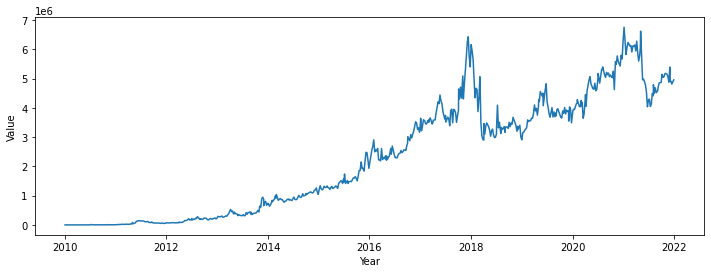

In [5]:
plt.figure(figsize=(12,4))
plt.plot(active_addresses["Timestamp"], active_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

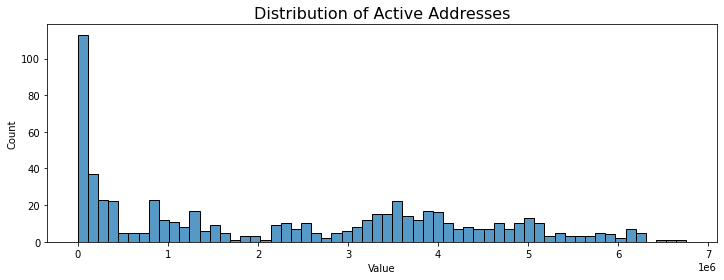

In [6]:
plt.figure(figsize=(12,4))
sns.histplot(active_addresses["Value"], kde = False, bins = 60)
plt.title('Distribution of Active Addresses', fontsize=16)
plt.show()

<IPython.core.display.Javascript object>


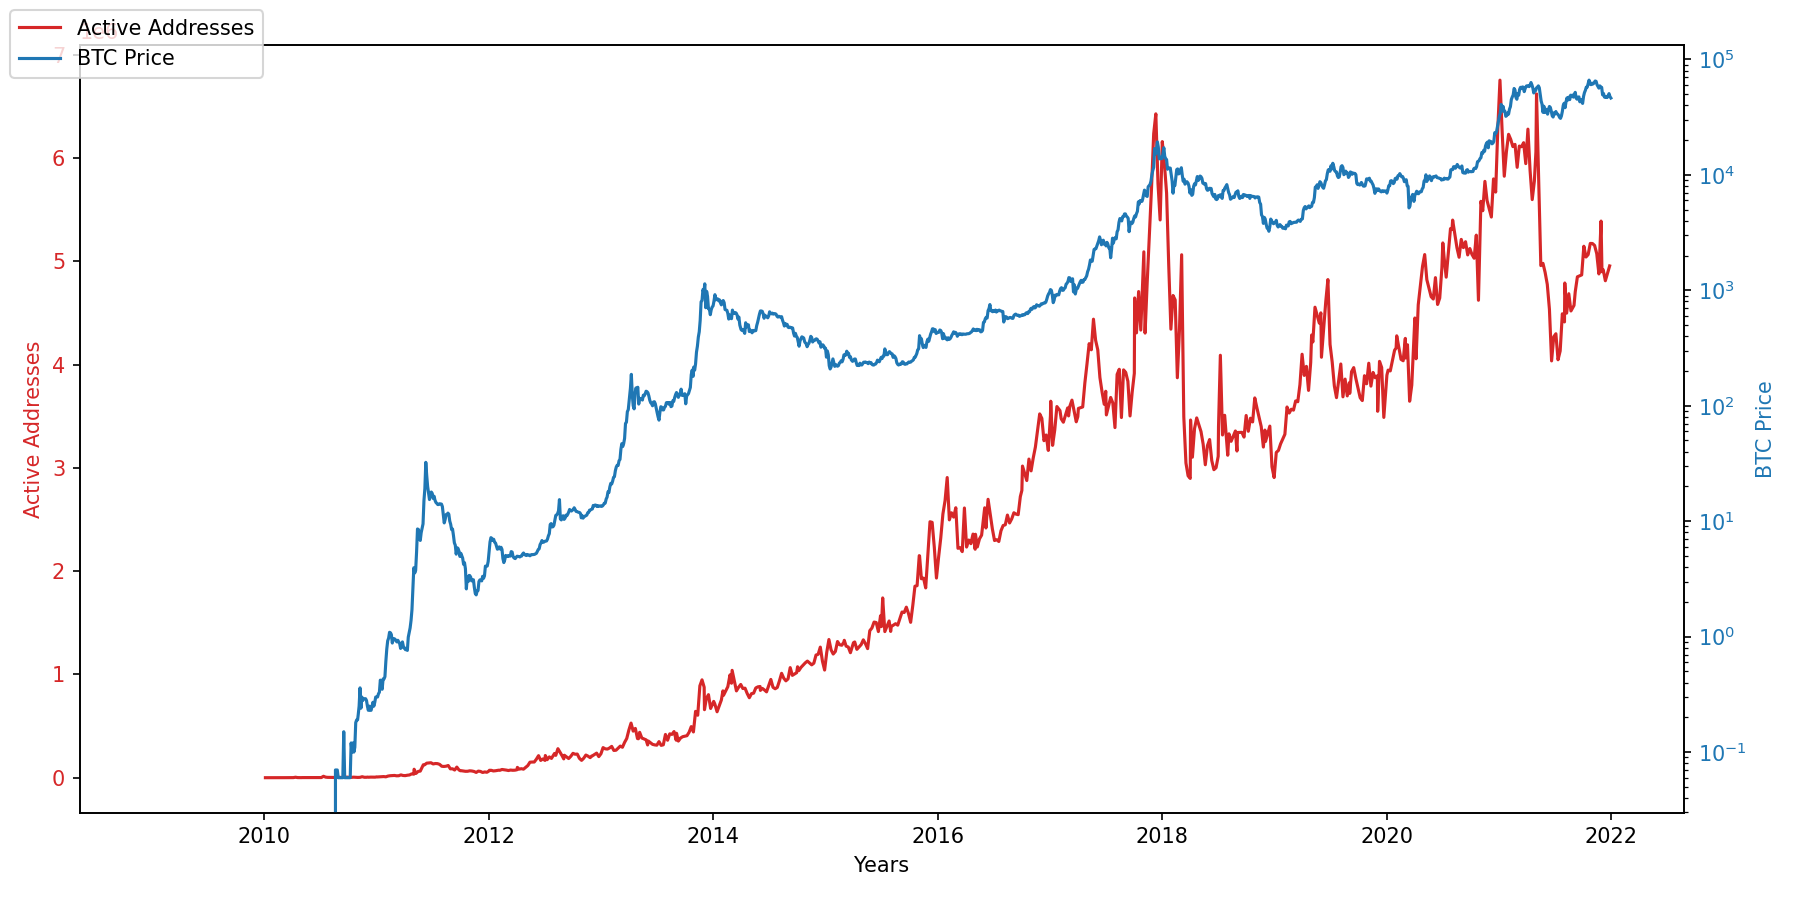

In [8]:
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

################ RIMUOVO DATE 2009 E 2022
market_price = market_price[~(market_price['Timestamp'] < '2009-01-01')]
market_price = market_price[~(market_price['Timestamp'] > '2021-12-31')]


fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:red'
ax1.set_xlabel('Years')
ax1.set_ylabel('Active Addresses', color=color)
ax1.plot(active_addresses["Timestamp"], active_addresses["Value"], color=color, label='Active Addresses')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('BTC Price', color=color)  # we already handled the x-label with ax1
ax2.plot(market_price["Timestamp"], market_price["Price"], color=color, label='BTC Price')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.legend(loc="upper left")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Shorter time series
Same as market price

In [7]:
activeh = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2016) & (active_addresses["Timestamp"].dt.year < 2022),:]
activen = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2016) & (active_addresses["Timestamp"].dt.year < 2021),:]
activenh = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2012) & (active_addresses["Timestamp"].dt.year < 2021),:]
activef = active_addresses.loc[(active_addresses["Timestamp"].dt.year > 2012) & (active_addresses["Timestamp"].dt.year < 2022),:]

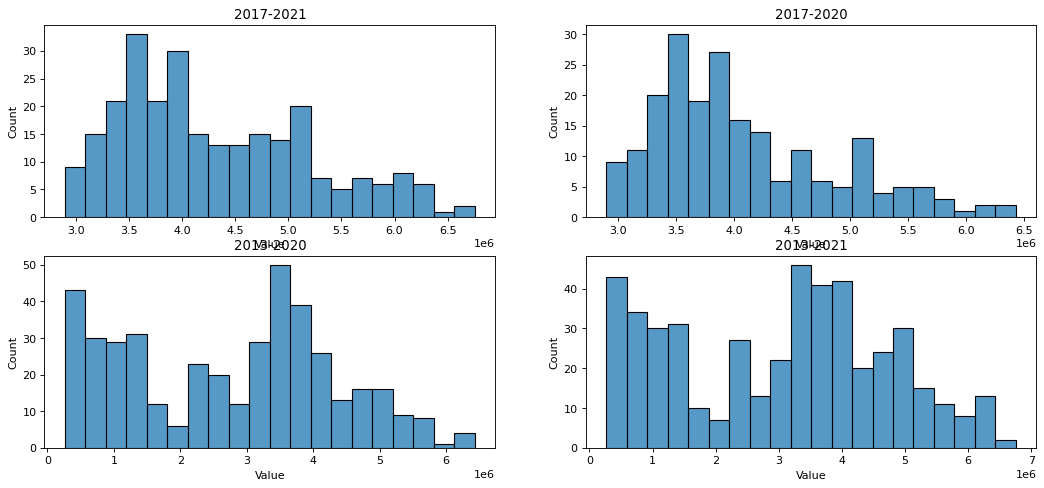

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16,7), dpi= 80)
sns.histplot(activeh["Value"], ax=axes[0,0],bins = 20)
sns.histplot(activen["Value"], ax=axes[0,1],bins = 20)
sns.histplot(activenh["Value"], ax=axes[1,0],bins = 20)
sns.histplot(activef["Value"], ax=axes[1,1],bins = 20)
axes[0,0].title.set_text('2017-2021')
axes[0,1].title.set_text('2017-2020')
axes[1,0].title.set_text('2013-2020')
axes[1,1].title.set_text('2013-2021')

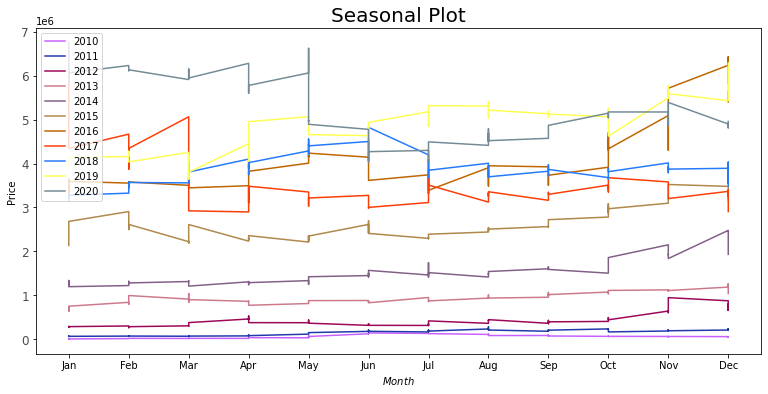

In [11]:
# Prepare data
active_addresses['year'] = [d.year for d in active_addresses["Timestamp"]]
active_addresses['month'] = [d.strftime('%b') for d in active_addresses["Timestamp"]]
years = active_addresses['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(matplotlib.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(13,6))
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', "Value", data=active_addresses.loc[active_addresses.year==y, :], color=mycolors[i], label=y)
# Decoration
plt.gca().set(ylabel= "Price", xlabel = '$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot", fontsize=20)
plt.legend(years, loc='upper left')
plt.show()

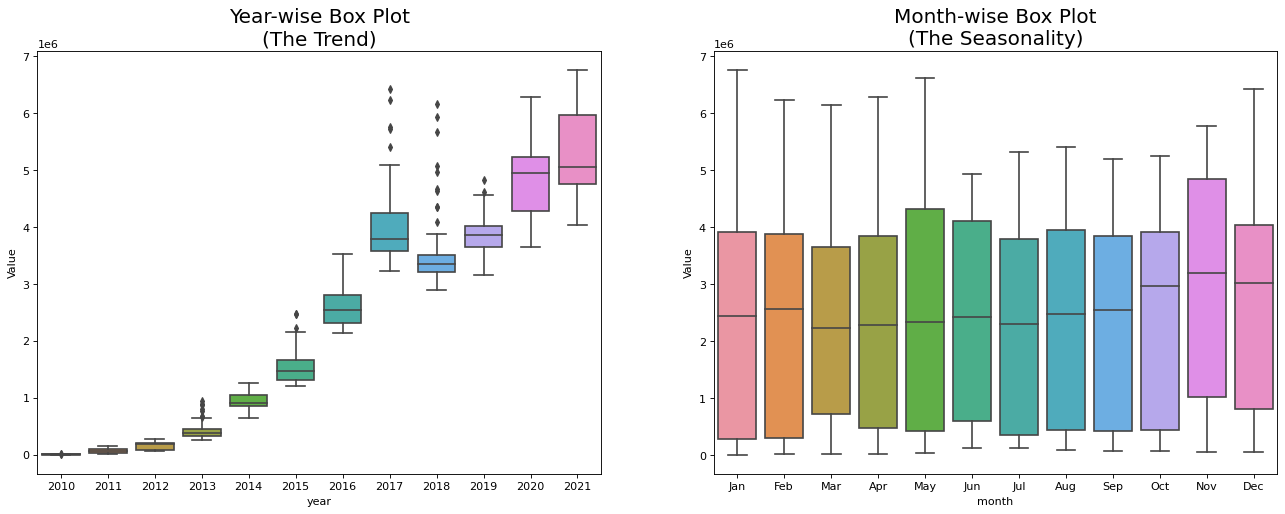

In [20]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y="Value", data=active_addresses, ax=axes[0])
sns.boxplot(x='month', y="Value", data=active_addresses.loc[~active_addresses.year.isin([2010, 2022]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Sesonal analysis

We use STL and compare robust = True and False

In [12]:
res1 = STL(active_addresses["Value"], period = 52, robust = True).fit()
res2 = STL(active_addresses["Value"], period = 52).fit()

Text(0.5, 0.98, 'ACTIVE ADDRESSES / 2010-2021 ')

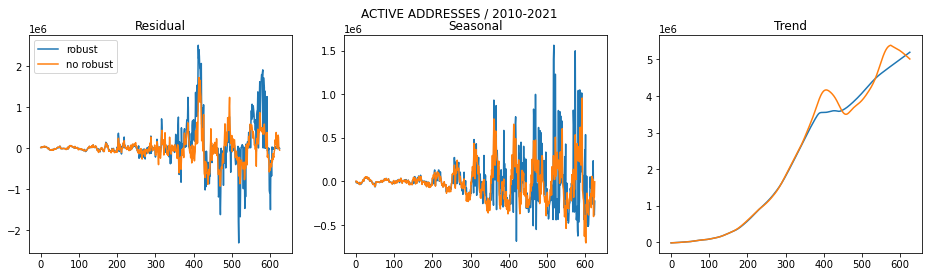

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(16,4))
axs[0].plot(res1.resid, label="robust")
axs[0].plot(res2.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res1.seasonal)
axs[1].plot(res2.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res1.trend)
axs[2].plot(res2.trend)
axs[2].title.set_text('Trend')


fig.suptitle('ACTIVE ADDRESSES / 2010-2021 ')

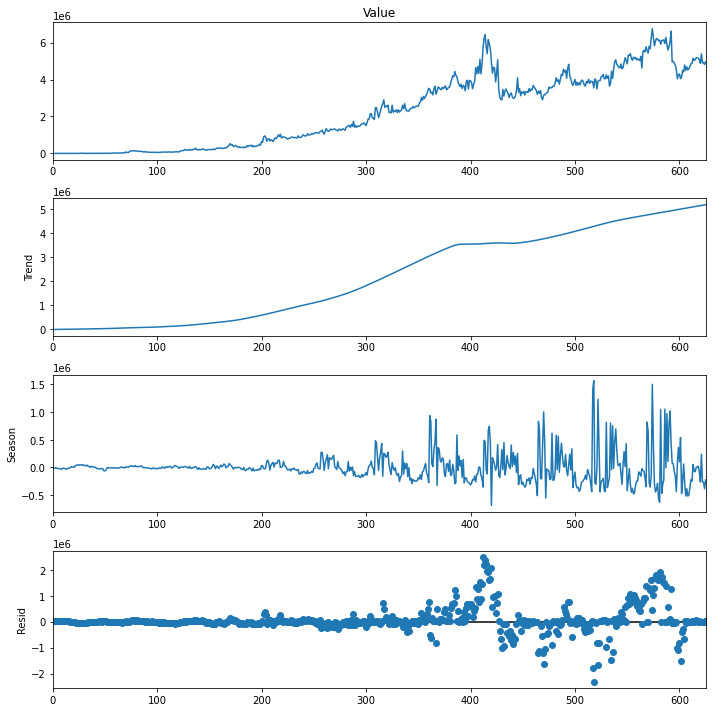

In [16]:
plt.rc("figure", figsize=(10, 10))
fig = res1.plot() #BIGGER VIEW

Since we see that the plot with the logarithmic scale is quite regular (below) we repeat the decomposition analysis after log-transforming the time series

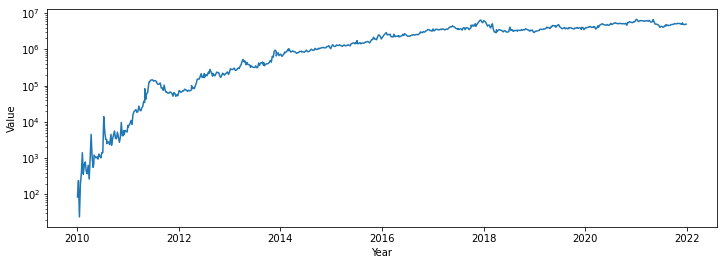

In [17]:
plt.figure(figsize=(12,4))
plt.plot(active_addresses["Timestamp"], active_addresses["Value"])
plt.gca().set(xlabel="Year", ylabel="Value")
#scommentare riga giù per visualizzare in scala log
plt.yscale('log') 
plt.show()

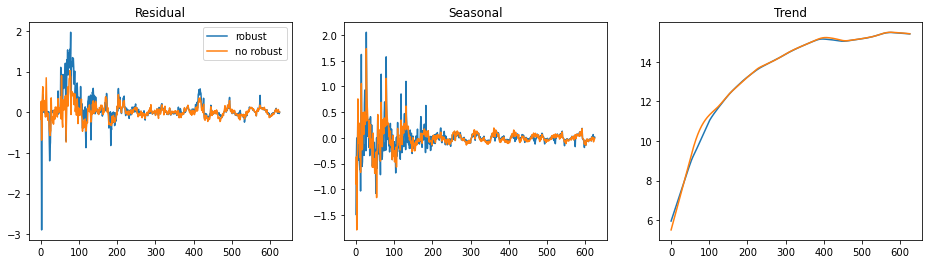

In [19]:
res3 = STL(np.log(active_addresses["Value"]), period = 52, robust = True).fit()
res4 = STL(np.log(active_addresses["Value"]), period = 52).fit()
fig, axs = plt.subplots(ncols=3, figsize=(16,4))
axs[0].plot(res3.resid, label="robust")
axs[0].plot(res4.resid, label="no robust")
axs[0].legend()
axs[0].title.set_text('Residual')
axs[1].plot(res3.seasonal)
axs[1].plot(res4.seasonal)
axs[1].title.set_text('Seasonal')
axs[2].plot(res3.trend)
axs[2].plot(res4.trend)
axs[2].title.set_text('Trend')

# TRAIN/VAL/TEST SPLIT

In [20]:
series = active_addresses['Value']

# Create train data set
train_split_date = '2018-02-26'
train_split_index = np.where(active_addresses.Timestamp == train_split_date)[0][0]
x_train = active_addresses.loc[active_addresses['Timestamp'] <= train_split_date]['Value']

# Create test data set
test_split_date = '2020-01-27'
test_split_index = np.where(active_addresses.Timestamp == test_split_date)[0][0]
x_test = active_addresses.loc[active_addresses['Timestamp'] >= test_split_date]['Value']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = active_addresses.loc[(active_addresses['Timestamp'] < test_split_date) & (active_addresses['Timestamp'] > train_split_date)]['Value']

Train set ranging from 2010-01-04 to 2018-02-26 00:00:00 - Number of days = 426
Validation set ranging from 2018-03-05 00:00:00 to 2020-01-13 00:00:00 - Number of days = 99
Test set ranging from 2020-01-27 00:00:00 to 2021-12-27 00:00:00 - Number of days = 101


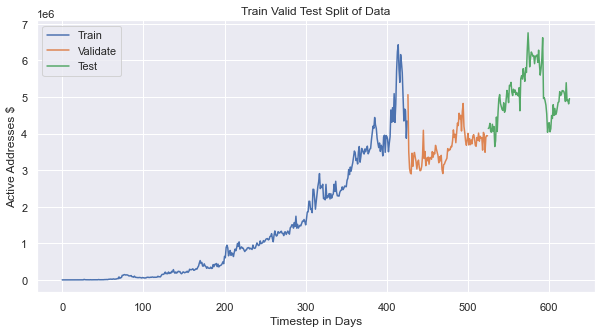

In [21]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 5]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Active Addresses $')
plt.xlabel('Timestep in Days')
plt.legend()
#print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())
print("Train set ranging from 2010-01-04 to", active_addresses.iloc[425]["Timestamp"], "- Number of days =", len(x_train.index))
print("Validation set ranging from", active_addresses.iloc[x_valid.index.min()]["Timestamp"], "to", active_addresses.iloc[x_valid.index.max()]["Timestamp"], "- Number of days =", len(x_valid.index))
print("Test set ranging from", active_addresses.iloc[x_test.index.min()]["Timestamp"], "to", active_addresses.iloc[x_test.index.max()]["Timestamp"], "- Number of days =", len(x_test.index))

In [22]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting

A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.


Text(0.5, 1.0, 'Active addresses')

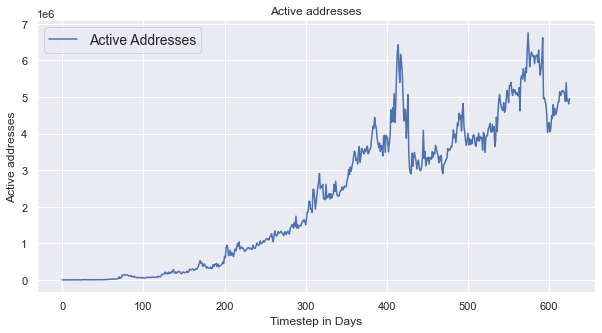

In [23]:
# Plot chart with all details untouched
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """[Plot the series data over a time range]
    Args:
        time (data range): [The entire time span of the data in range format]
        series ([integers]): [Series value corresponding to its point on the time axis]
        format (str, optional): [Graph type]. Defaults to "-".
        start (int, optional): [Time to start time series data]. Defaults to 0.
        end ([type], optional): [Where to stop time data]. Defaults to None.
        label ([str], optional): [Label name of series]. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
plot_series(time=active_addresses.index,series=active_addresses['Value'], label = 'Active Addresses')
plt.ylabel('Active addresses')
plt.xlabel('Timestep in Days')
plt.title('Active addresses')

In [24]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Active Addresses Forecast vs Actual')

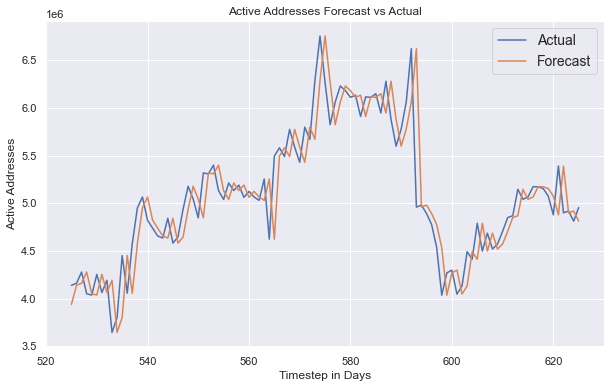

In [25]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('Active Addresses Forecast vs Actual')

#### Calculate Error in Naive Model

In [26]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = mean_absolute_error(x_test, naive_forecast)
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 224349.71287128713}

# Monthly Moving Average Model (20 Day MA)

Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.


In [34]:
a = pd.Series([2,3,4,5,4,3,2,3,4,3,2,3]).rolling(5).mean()
a

0     NaN
1     NaN
2     NaN
3     NaN
4     3.6
5     3.8
6     3.6
7     3.4
8     3.2
9     3.0
10    2.8
11    3.0
dtype: float64

In [ ]:
## Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = active_addresses['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - 2:active_addresses.index.max()-1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')


In [30]:
ma_20 = mean_absolute_error(x_test, moving_avg_forecast)

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 224349.71287128713, 'SMA 20': 508999.7732673267}

# Weekly Moving Average (5 day MA)

I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

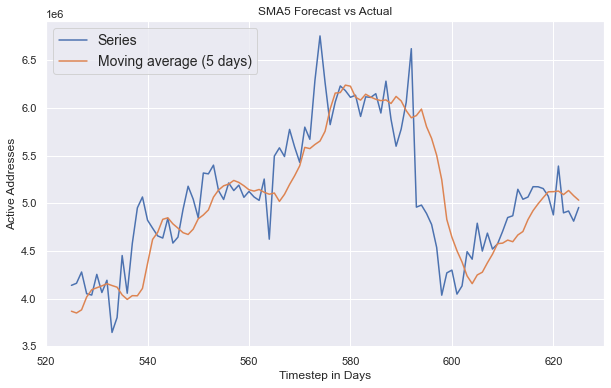

In [35]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = active_addresses['Value'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - 2:active_addresses.index.max() - 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Active Addresses')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [36]:
# Calculate MAE
ma_5 = mean_absolute_error(x_test, moving_avg_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 508999.7732673267,
 'SMA 5': 297835.68910891085}

# ARIMA
Step 1: Is the data stationary? Use Augmented Dickey Fuller test to determine if the data is stationary

Failure to reject the null hypothesis means the data is not stationary


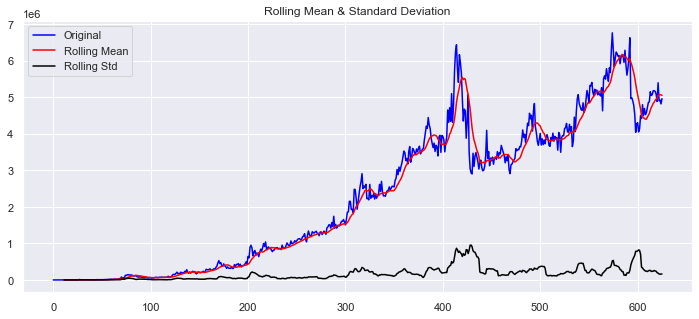

Results of Dickey-Fuller Test:
p-value = 0.8497. The series is likely non-stationary.
Test Statistic                  -0.688653
p-value                          0.849667
#Lags Used                      17.000000
Number of Observations Used    608.000000
Critical Value (1%)             -3.441151
Critical Value (5%)             -2.866305
Critical Value (10%)            -2.569308
dtype: float64


In [38]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
test_stationarity(series)


The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary. Since our data is not stationary

# Step 2 Differencing

We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.


In [39]:
# Get the difference of each Adj Close point
active_addresses_diff_1 = series.diff()
active_addresses_diff_1.dropna(inplace=True)

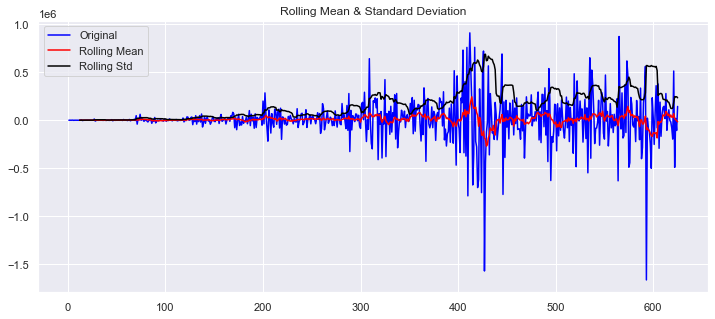

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.635426e+00
p-value                        1.958239e-11
#Lags Used                     1.600000e+01
Number of Observations Used    6.080000e+02
Critical Value (1%)           -3.441151e+00
Critical Value (5%)           -2.866305e+00
Critical Value (10%)          -2.569308e+00
dtype: float64


In [40]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(active_addresses_diff_1)

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We reject the null hypothesis. So, the time series is in fact stationary.

# Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps. The difference between autocorrelation and partial autocorrelation can be difficult and confusing for beginners to time series forecasting.

Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

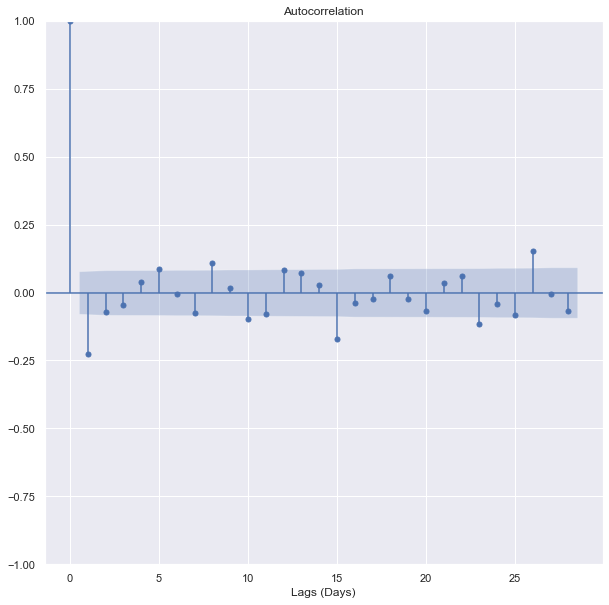

In [65]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(active_addresses_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


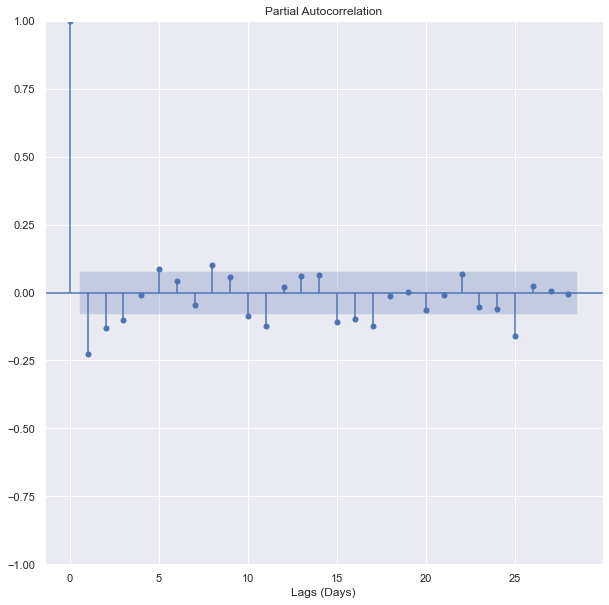

In [66]:
plot_pacf(active_addresses_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

- Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, we will use the 1st lag as a moving average point.

- For the PACF plot, at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.

- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term.

# Testing different ARIMA models

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=11391.875, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11429.271, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11388.286, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11390.464, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11428.871, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=11416.076, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=11390.073, Time=0.14 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=11390.216, Time=0.25 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=11391.291, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=11391.457, Time=0.41 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=11394.428, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=11389.611, Time=0.09 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=11387.351, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=

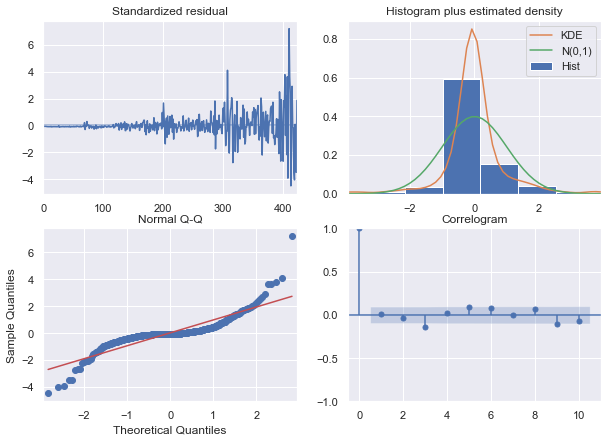

In [41]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(x_train, exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = seasonal_flag, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

    
# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'


input_seasonality = 7


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
# Get actual values
actuals = x_test.reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = x_train, seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))

elif input_ts_algo == 'manual_sarima':
    input_order = (3,1,0)
    input_seasonal_order = (2,1,1,7)
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = x_train, order = input_order, seasonal_order = input_seasonal_order)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = x_train)


Abbiamo trovato che il miglior modello è ARIMA(0,1,1)(1,0,0)[7].

In [42]:
import statsmodels.api as sm

# fit model
active_arima = sm.tsa.arima.ARIMA(x_train, order=(0,1,1), seasonal_order=(1,0,0,7))
active_arima_fit = active_arima.fit()
print(active_arima_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            Value   No. Observations:                  426
Model:             ARIMA(0, 1, 1)x(1, 0, [], 7)   Log Likelihood               -5691.891
Date:                          Wed, 09 Nov 2022   AIC                          11389.781
Time:                                  12:01:57   BIC                          11401.938
Sample:                                       0   HQIC                         11394.584
                                          - 426                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1431      0.021     -6.771      0.000      -0.184      -0.102
ar.S.L7       -0.2825      0.021    -13.616      0.

NormaltestResult(statistic=133.02830732954905, pvalue=1.2979862591473577e-29)
This distribution is not a normal distribution


C:\Users\paletto\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


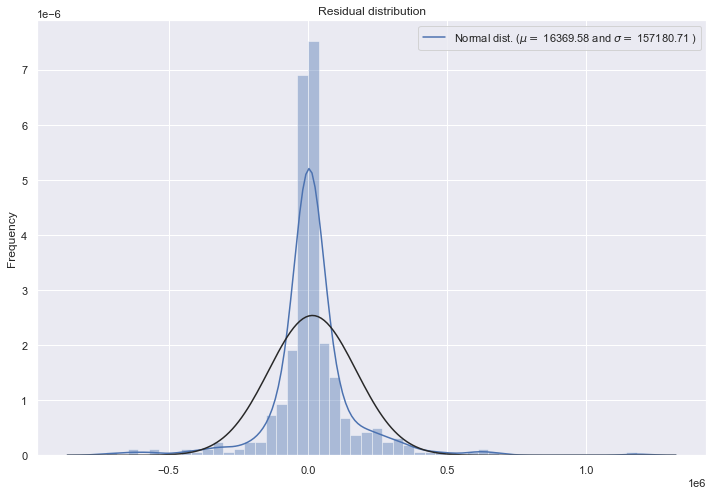

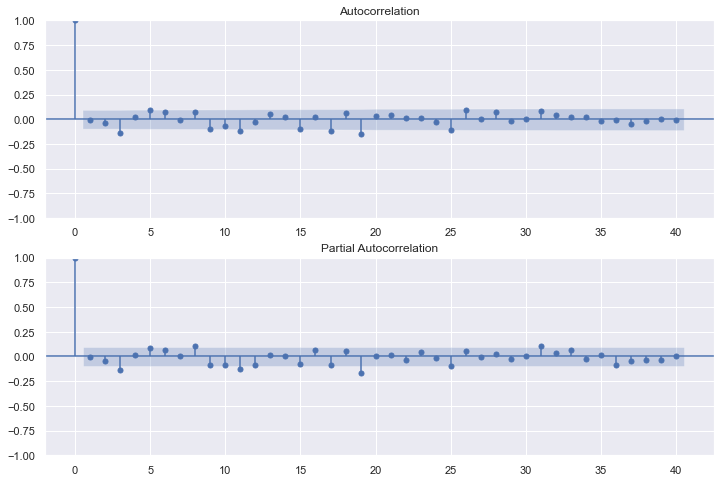

In [43]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = active_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

# Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (0,1,1)(1,0,0,7) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [49]:
# Create list of x train valuess
history = [x for x in x_valid]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(0,1,1), seasonal_order=(1,0,0,7))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

#%store model_predictions

Testing Mean Squared Error is 219779.14264712404


In [77]:
output

array([4845624.11417583])

In [46]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_test, model_predictions)

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 508999.7732673267,
 'SMA 5': 297835.68910891085,
 'ARIMA': 219779.14264712404}

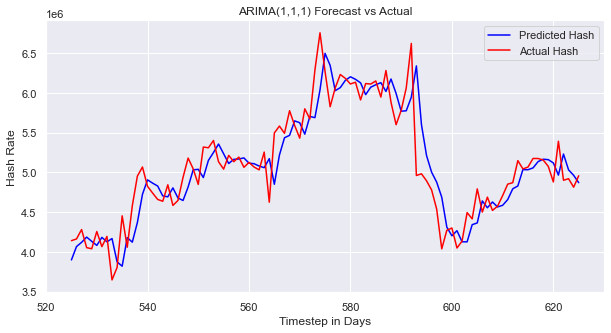

<Figure size 720x432 with 0 Axes>

In [47]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-N_test_observations:], model_predictions[-N_test_observations:], color='blue',label='Predicted Hash')
plt.plot(x_test.index[-N_test_observations:], x_test[-N_test_observations:], color='red', label='Actual Hash')
plt.ylabel('Hash Rate')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [82]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

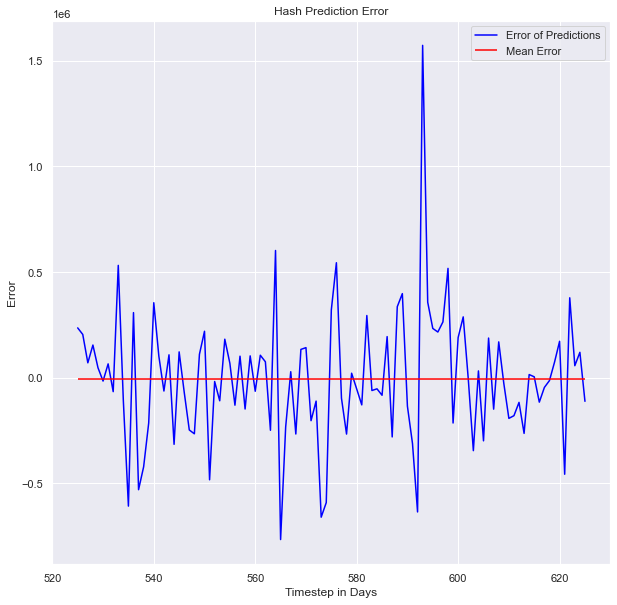

<Figure size 720x432 with 0 Axes>

In [83]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('Hash Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [50]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 508999.7732673267,
 'SMA 5': 297835.68910891085,
 'ARIMA': 219779.14264712404}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

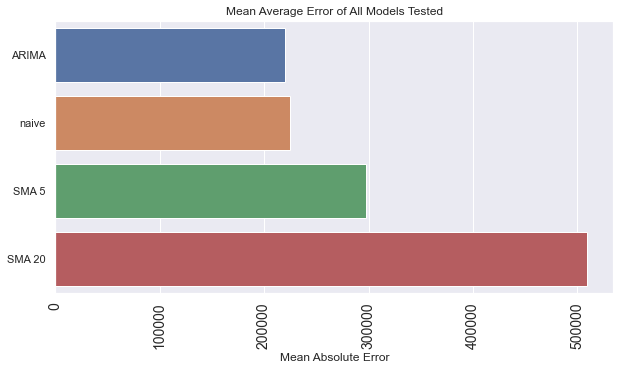

In [51]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# LSTM

In [52]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 6]

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [55]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

# secondo me non ha senso fare la norm min-max perchè sappiamo già che sia val che test set sono tutti più alti
# del train set, dato che il grafico è crescente, quindi i valori di val e test sarebbero tutti sopra 1
# in ogni caso, dato che altrimenti le X avrebbero valori tanto alti, va bene così

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()


In [54]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

#### Find the learning rate

In [56]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
21/21 [==============================] - 2s 21ms/step - loss: 0.0467 - mae: 0.2015 - lr: 1.0000e-05
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0440 - mae: 0.1936 - lr: 1.1220e-05
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0414 - mae: 0.1870 - lr: 1.2589e-05
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0387 - mae: 0.1803 - lr: 1.4125e-05
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0358 - mae: 0.1730 - lr: 1.5849e-05
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0327 - mae: 0.1649 - lr: 1.7783e-05
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0292 - mae: 0.1559 - lr: 1.9953e-05
Epoch 8/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0254 - mae: 0.1460 - lr: 2.2387e-05
Epoch 9/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0213 - mae: 0.1348 - lr: 2.5119e-05


21/21 [==============================] - 0s 5ms/step - loss: 0.2843 - mae: 0.6090 - lr: 0.0501
Epoch 76/100
21/21 [==============================] - 0s 5ms/step - loss: 0.6935 - mae: 1.1730 - lr: 0.0562
Epoch 77/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0219 - mae: 0.1591 - lr: 0.0631
Epoch 78/100
21/21 [==============================] - 0s 5ms/step - loss: 0.1227 - mae: 0.4075 - lr: 0.0708
Epoch 79/100
21/21 [==============================] - 0s 5ms/step - loss: 0.1930 - mae: 0.5509 - lr: 0.0794
Epoch 80/100
21/21 [==============================] - 0s 5ms/step - loss: 0.2556 - mae: 0.6609 - lr: 0.0891
Epoch 81/100
21/21 [==============================] - 0s 5ms/step - loss: 0.3367 - mae: 0.7948 - lr: 0.1000
Epoch 82/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0523 - mae: 0.2881 - lr: 0.1122
Epoch 83/100
21/21 [==============================] - 0s 5ms/step - loss: 0.3601 - mae: 0.8225 - lr: 0.1259
Epoch 84/100
21/21 [=====================

(1e-05, 1.0, 0.0, 0.1)

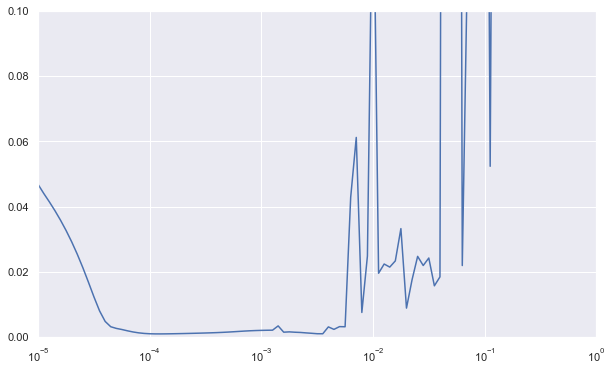

In [57]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.1])

In [58]:
#This is the best learning rate
history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]
#Arrotondo a 0.00062

0.00012589255

In [59]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.00012)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
      7/Unknown - 2s 9ms/step - loss: 6.4140e-04 - mae: 0.0234   

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


14/14 [==============================] - 6s 318ms/step - loss: 0.0245 - mae: 0.1502 - val_loss: 0.0512 - val_mae: 0.3131
Epoch 2/500
 9/14 [==================>...........] - ETA: 0s - loss: 8.1344e-04 - mae: 0.0364

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


14/14 [==============================] - 4s 279ms/step - loss: 0.0105 - mae: 0.0992 - val_loss: 0.0130 - val_mae: 0.1472
Epoch 3/500
14/14 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0643

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


14/14 [==============================] - 4s 290ms/step - loss: 0.0035 - mae: 0.0643 - val_loss: 0.0038 - val_mae: 0.0636
Epoch 4/500
14/14 [==============================] - 0s 9ms/step - loss: 0.0026 - mae: 0.0620 - val_loss: 0.0098 - val_mae: 0.1118
Epoch 5/500
14/14 [==============================] - 0s 8ms/step - loss: 0.0021 - mae: 0.0568 - val_loss: 0.0117 - val_mae: 0.1226
Epoch 6/500
14/14 [==============================] - 0s 9ms/step - loss: 0.0014 - mae: 0.0451 - val_loss: 0.0130 - val_mae: 0.1296
Epoch 7/500
14/14 [==============================] - 0s 8ms/step - loss: 0.0011 - mae: 0.0364 - val_loss: 0.0142 - val_mae: 0.1355
Epoch 8/500
14/14 [==============================] - 0s 8ms/step - loss: 8.6866e-04 - mae: 0.0300 - val_loss: 0.0148 - val_mae: 0.1386
Epoch 9/500
14/14 [==============================] - 0s 9ms/step - loss: 7.9533e-04 - mae: 0.0261 - val_loss: 0.0152 - val_mae: 0.1404
Epoch 10/500
14/14 [==============================] - 0s 11ms/step - loss: 7.7358e-04

### Make predictions

In [61]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(101,)

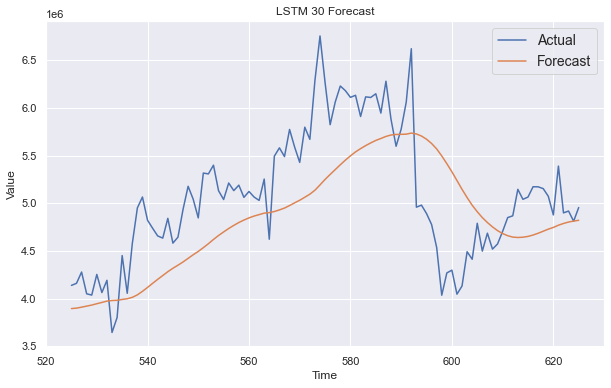

In [62]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [63]:
# calculate MAE
lstm = mean_absolute_error(x_test, rnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['LSTM'] = lstm
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 508999.7732673267,
 'SMA 5': 297835.68910891085,
 'ARIMA': 219779.14264712404,
 'LSTM': 496220.20544554456}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

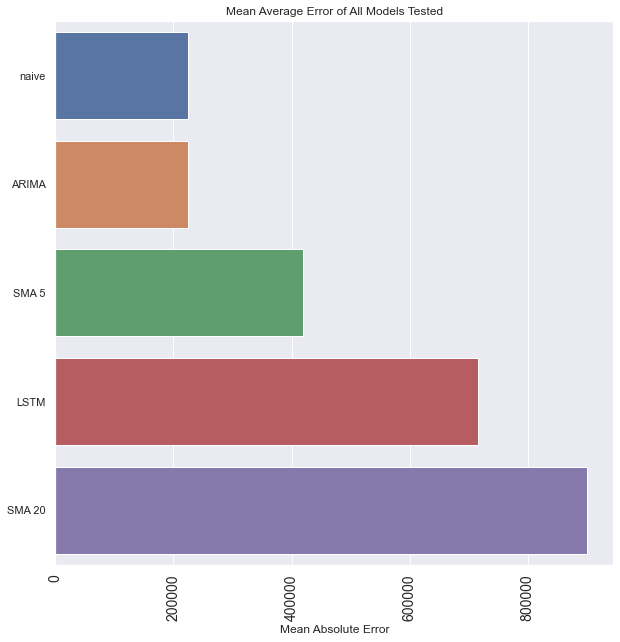

In [103]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

# CNN

In [66]:
def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Find the learning rate

In [67]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
4/4 [==============================] - 1s 13ms/step - loss: 0.0434 - mae: 0.1970 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0426 - mae: 0.1944 - lr: 1.0798e-04
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0418 - mae: 0.1919 - lr: 1.1659e-04
Epoch 4/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0410 - mae: 0.1892 - lr: 1.2589e-04
Epoch 5/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0401 - mae: 0.1865 - lr: 1.3594e-04
Epoch 6/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0392 - mae: 0.1840 - lr: 1.4678e-04
Epoch 7/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0382 - mae: 0.1813 - lr: 1.5849e-04
Epoch 8/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0371 - mae: 0.1786 - lr: 1.7113e-04
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0359 - mae: 0.1756 - lr: 1.8478e-04
Epoch 10/100
4/4 [

Epoch 76/100
4/4 [==============================] - 0s 7ms/step - loss: 1.5315 - mae: 1.8897 - lr: 0.0316
Epoch 77/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0280 - mae: 0.1663 - lr: 0.0341
Epoch 78/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0235 - mae: 0.1708 - lr: 0.0369
Epoch 79/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0234 - mae: 0.1789 - lr: 0.0398
Epoch 80/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0233 - mae: 0.1762 - lr: 0.0430
Epoch 81/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0233 - mae: 0.1740 - lr: 0.0464
Epoch 82/100
4/4 [==============================] - 0s 7ms/step - loss: 0.0232 - mae: 0.1746 - lr: 0.0501
Epoch 83/100
4/4 [==============================] - 0s 9ms/step - loss: 0.0234 - mae: 0.1722 - lr: 0.0541
Epoch 84/100
4/4 [==============================] - 0s 8ms/step - loss: 0.0236 - mae: 0.1774 - lr: 0.0584
Epoch 85/100
4/4 [============================

(0.0001, 0.1, 0.0, 0.04)

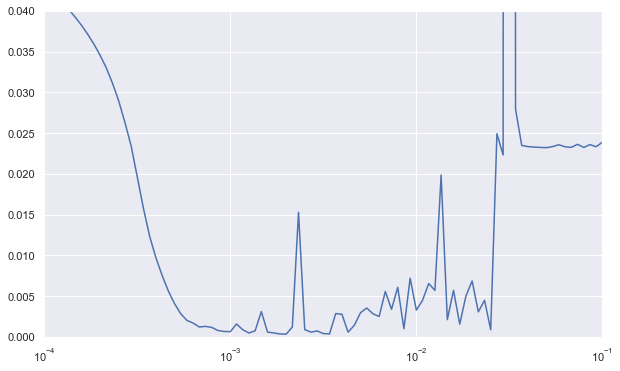

In [68]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .04])

In [69]:
#This is the best learning rate
history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

0.0019952622

In [70]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=0.001)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
4/4 [==============================] - 1s 141ms/step - loss: 0.0354 - mae: 0.1773 - val_loss: 0.0922 - val_mae: 0.4228
Epoch 2/500
4/4 [==============================] - 0s 72ms/step - loss: 0.0145 - mae: 0.1205 - val_loss: 0.0230 - val_mae: 0.1826
Epoch 3/500
4/4 [==============================] - 0s 57ms/step - loss: 0.0060 - mae: 0.0871 - val_loss: 0.0098 - val_mae: 0.0936
Epoch 4/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0028 - mae: 0.0549 - val_loss: 0.0352 - val_mae: 0.2587
Epoch 5/500
4/4 [==============================] - 0s 55ms/step - loss: 0.0040 - mae: 0.0561 - val_loss: 0.0034 - val_mae: 0.0648
Epoch 6/500
4/4 [==============================] - 0s 52ms/step - loss: 7.5782e-04 - mae: 0.0264 - val_loss: 0.0093 - val_mae: 0.1274
Epoch 7/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0017 - mae: 0.0400 - val_loss: 0.0059 - val_mae: 0.0963
Epoch 8/500
4/4 [==============================] - 0s 57ms/step - loss: 9.6534e-04 - 

4/4 [==============================] - 0s 49ms/step - loss: 5.4986e-04 - mae: 0.0214 - val_loss: 7.3036e-04 - val_mae: 0.0297
Epoch 62/500
4/4 [==============================] - 0s 50ms/step - loss: 2.7344e-04 - mae: 0.0140 - val_loss: 6.5597e-04 - val_mae: 0.0278
Epoch 63/500
4/4 [==============================] - 0s 51ms/step - loss: 2.5373e-04 - mae: 0.0131 - val_loss: 0.0014 - val_mae: 0.0429
Epoch 64/500
4/4 [==============================] - 0s 51ms/step - loss: 6.9047e-04 - mae: 0.0243 - val_loss: 7.3100e-04 - val_mae: 0.0299
Epoch 65/500
4/4 [==============================] - 0s 49ms/step - loss: 3.2251e-04 - mae: 0.0155 - val_loss: 8.9492e-04 - val_mae: 0.0338
Epoch 66/500
4/4 [==============================] - 0s 52ms/step - loss: 3.6687e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mae: 0.0368
Epoch 67/500
4/4 [==============================] - 0s 49ms/step - loss: 3.3805e-04 - mae: 0.0160 - val_loss: 7.0162e-04 - val_mae: 0.0293
Epoch 68/500
4/4 [==============================

In [71]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [72]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(101,)

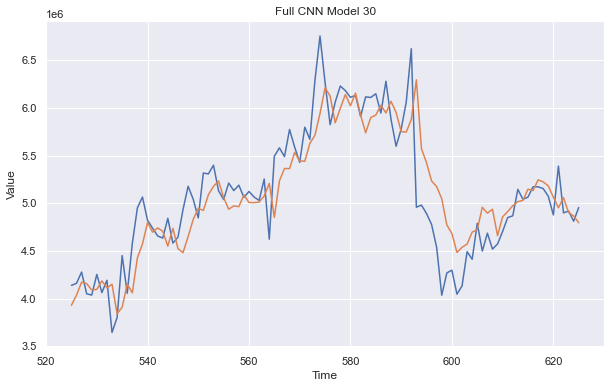

In [73]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Hash rate')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [74]:
# Calculate MAE
cnn = mean_absolute_error(x_test, cnn_unscaled_forecast)

# Save to our dictionary of model mae scores
model_mae_scores['CNN'] = cnn
model_mae_scores

{'naive': 224349.71287128713,
 'SMA 20': 508999.7732673267,
 'SMA 5': 297835.68910891085,
 'ARIMA': 219779.14264712404,
 'LSTM': 496220.20544554456,
 'CNN': 250777.74752475249}

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

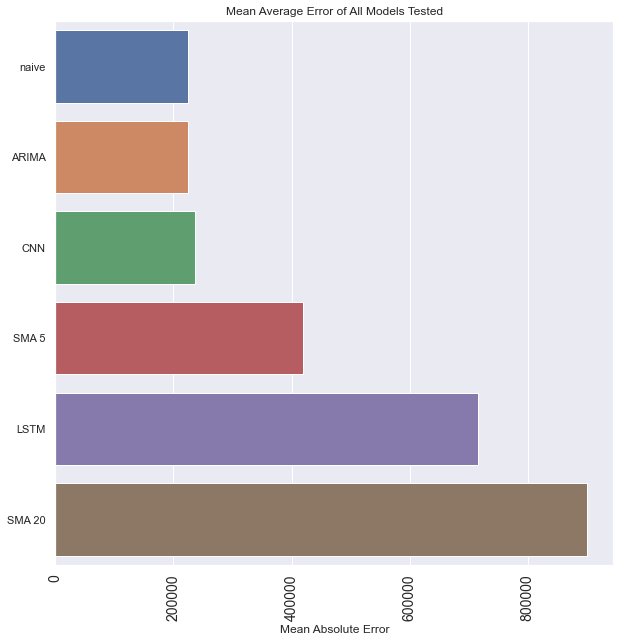

In [114]:
mae_series = pd.Series(model_mae_scores)
model_mae_scores

# Sort vales for clean bar chart
order = mae_series.sort_values()

# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')

## Weekly data

In [81]:
aa_week = active_addresses.set_index('Timestamp')
aa_week = aa_week['Value'].resample('W').mean()

aa_week = aa_week.dropna().reset_index()

In [83]:
tr_idx_w = aa_week.index[int((train_split_index/active_addresses.shape[0])*aa_week.shape[0])]
te_idx_w = aa_week.index[int((test_split_index/active_addresses.shape[0])*aa_week.shape[0])]
print('data fine train =',aa_week['Timestamp'][tr_idx_w], ' data inizio test =', aa_week['Timestamp'][te_idx_w])

data fine train = 2018-02-25 00:00:00  data inizio test = 2020-01-19 00:00:00


In [85]:
x_trw = aa_week.loc[:tr_idx_w,'Value']
x_tew = aa_week.loc[te_idx_w:,'Value']
x_vaw = aa_week.loc[tr_idx_w:te_idx_w,'Value']

x_trw_d = aa_week.diff().loc[:tr_idx_w,'Value'].dropna()
x_tew_d = aa_week.diff().loc[te_idx_w:,'Value']
x_vaw_d = aa_week.diff().loc[tr_idx_w:te_idx_w,'Value']

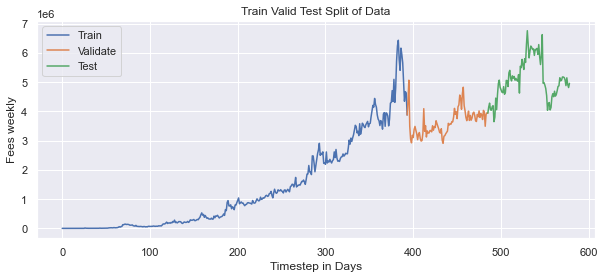

In [89]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 4]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_trw, label = 'Train')
plt.plot(x_vaw, label = 'Validate')
plt.plot(x_tew, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Fees weekly')
plt.xlabel('Timestep in Days')
plt.legend()

## ARIMA

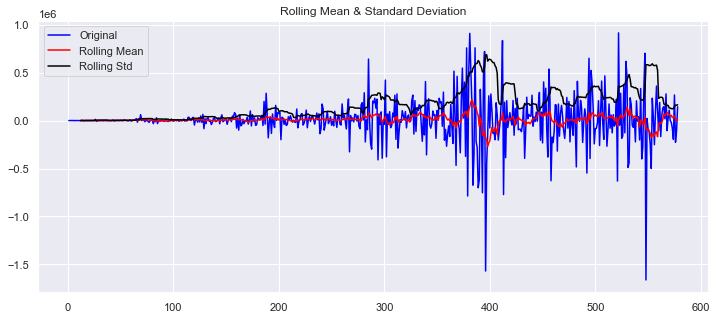

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.292409e+00
p-value                        1.405997e-10
#Lags Used                     1.700000e+01
Number of Observations Used    5.600000e+02
Critical Value (1%)           -3.442081e+00
Critical Value (5%)           -2.866715e+00
Critical Value (10%)          -2.569526e+00
dtype: float64


In [90]:
test_stationarity(aa_week['Value'].diff().dropna())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=11413.835, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=11429.271, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=11411.719, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=11411.771, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=11428.871, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=11416.076, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[5] intercept   : AIC=11413.403, Time=0.07 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=11413.611, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=11411.740, Time=0.05 sec
 ARIMA(1,1,0)(2,0,1)[5] intercept   : AIC=11401.165, Time=0.24 sec
 ARIMA(1,1,0)(2,0,2)[5] intercept   : AIC=11399.837, Time=0.41 sec
 ARIMA(1,1,0)(1,0,2)[5] intercept   : AIC=11396.859, Time=0.25 sec
 ARIMA(1,1,0)(0,0,2)[5] intercept   : AIC=11413.208, Time=0.07 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=11409.256, Time=0.24 sec
 ARIMA(2,1,0)(1,0,2

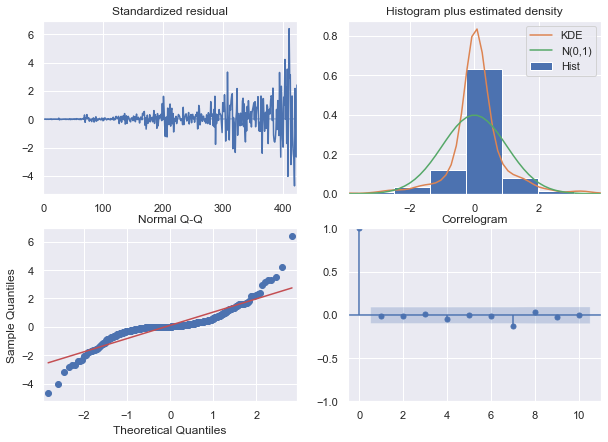

In [117]:
input_seasonality = 5
model = model_auto_sarimax(y = x_trw_d, seasonality = 5, seasonal_flag = True, exogenous_variable = None)

C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NormaltestResult(statistic=71.27426301075862, pvalue=3.3341907042421214e-16)
This distribution is not a normal distribution


C:\Users\paletto\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\paletto\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


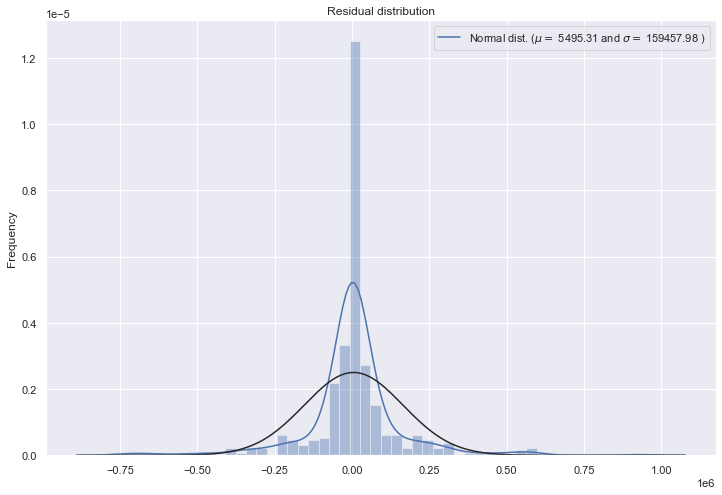

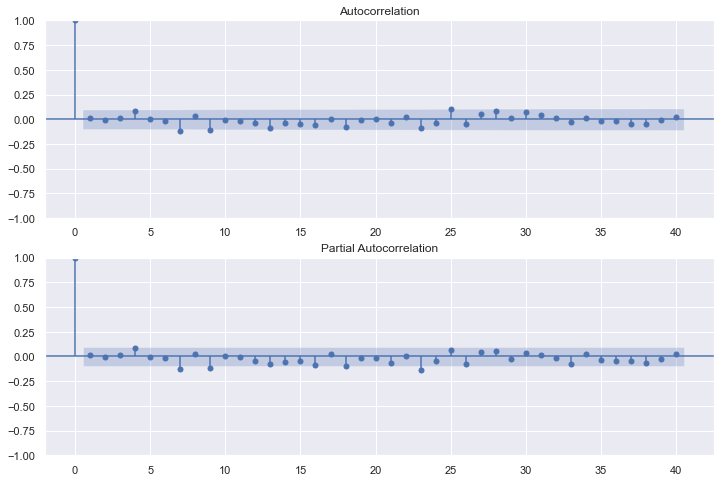

In [118]:
block_arima = sm.tsa.arima.ARIMA(x_trw_d, order=(3,1,1), seasonal_order=(1,0,2,5))
block_arima_fit = block_arima.fit()

residuals = block_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

In [119]:
# Create list of x train valuess
history = [x for x in pd.concat([x_trw_d,x_vaw_d], axis=0)] # pd.concat([x_trw_d,x_vaw_d], axis=0)

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_tew_d)

# loop through every data point
for time_point in list(x_tew_d.index[-N_test_observations:]):
    model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(1,0,2,5))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_tew_d[time_point]
    history.append(true_test_value)
        
MAE_error = mean_absolute_error(x_tew_d, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 219279.23932964442


In [120]:
model_w_mae_scores = {}

model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = mean_absolute_error(x_tew_d, model_predictions)

# Save to our dictionary of model mae scores
model_w_mae_scores['ARIMA'] = arima_mae
model_w_mae_scores

{'ARIMA': 219279.23932964442}

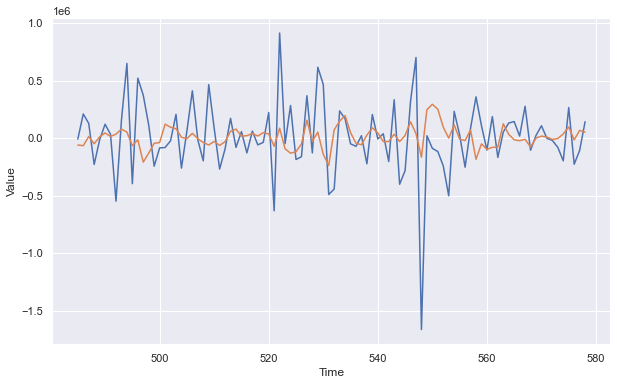

In [121]:
# Plot results
plt.figure(figsize=(10, 6))
plot_series(x_tew_d.index, x_tew_d)
plot_series(x_tew_d.index, model_predictions)

In [122]:
history = [x for x in pd.concat([x_trw_d,x_vaw_d], axis=0)]
model_predictions = []

# Count number of test data points
N_test_observations = len(x_tew_d)

model = sm.tsa.arima.ARIMA(history, order=(3,1,1), seasonal_order=(1,0,2,5))
model_fit = model.fit()

output = model_fit.forecast(N_test_observations)
for el in output:
    model_predictions.append(el)
    history.append(el)

MAE_error = mean_absolute_error(x_tew_d, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))

Testing Mean Squared Error is 223273.52264806817


In [123]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae2 = mean_absolute_error(x_tew_d, model_predictions)

# Save to our dictionary of model mae scores
model_w_mae_scores['ARIMA 2'] = arima_mae2
model_w_mae_scores

{'ARIMA': 219279.23932964442, 'ARIMA 2': 223273.52264806817}

## LSTM

In [137]:
#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_trw_d.values.reshape(-1,1))

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_vaw_d.values.reshape(-1,1))

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_tew_d.values.reshape(-1,1))

In [152]:
# SCELTA DEL LEARNING RATE
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
optimizer = keras.optimizers.Nadam(lr=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
19/19 [==============================] - 2s 9ms/step - loss: 0.1276 - mae: 0.4983 - lr: 1.0000e-05
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1185 - mae: 0.4797 - lr: 1.1220e-05
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1082 - mae: 0.4577 - lr: 1.2589e-05
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0968 - mae: 0.4323 - lr: 1.4125e-05
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0844 - mae: 0.4026 - lr: 1.5849e-05
Epoch 6/100
19/19 [==============================] - ETA: 0s - loss: 0.0690 - mae: 0.367 - 0s 7ms/step - loss: 0.0706 - mae: 0.3668 - lr: 1.7783e-05
Epoch 7/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0553 - mae: 0.3222 - lr: 1.9953e-05
Epoch 8/100
19/19 [==============================] - ETA: 0s - loss: 0.0379 - mae: 0.269 - 0s 7ms/step - loss: 0.0386 - mae: 0.2654 - lr: 2.2387e-05
Epoch 9/100
19/19 [=================

19/19 [==============================] - 0s 7ms/step - loss: 0.2612 - mae: 0.6582 - lr: 0.0447
Epoch 75/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0051 - mae: 0.0639 - lr: 0.0501
Epoch 76/100
19/19 [==============================] - 0s 7ms/step - loss: 0.2588 - mae: 0.5653 - lr: 0.0562
Epoch 77/100
19/19 [==============================] - 0s 7ms/step - loss: 0.5194 - mae: 1.0152 - lr: 0.0631
Epoch 78/100
19/19 [==============================] - 0s 7ms/step - loss: 0.3363 - mae: 0.7849 - lr: 0.0708
Epoch 79/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1860 - mae: 0.5432 - lr: 0.0794
Epoch 80/100
19/19 [==============================] - 0s 8ms/step - loss: 0.5586 - mae: 1.0561 - lr: 0.0891
Epoch 81/100
19/19 [==============================] - 0s 7ms/step - loss: 0.5829 - mae: 1.0808 - lr: 0.1000
Epoch 82/100
19/19 [==============================] - 0s 7ms/step - loss: 0.6408 - mae: 1.1400 - lr: 0.1122
Epoch 83/100
19/19 [=====================

(0.0001, 0.1, 0.004, 0.007)

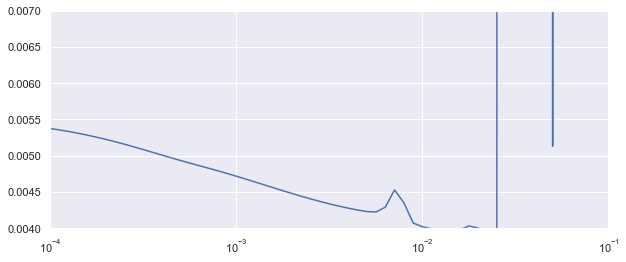

In [153]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0.004, 0.007])

In [154]:
#This is the best learning rate
history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

0.022387212

In [155]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.Nadam(lr=0.02)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
     14/Unknown - 2s 8ms/step - loss: 0.1602 - mae: 0.3615

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 6s 255ms/step - loss: 0.1212 - mae: 0.2961 - val_loss: 0.0211 - val_mae: 0.1443
Epoch 2/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0046 - mae: 0.0568 - val_loss: 0.0214 - val_mae: 0.1477
Epoch 3/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0043 - mae: 0.0550 - val_loss: 0.0216 - val_mae: 0.1479
Epoch 4/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0042 - mae: 0.0542 - val_loss: 0.0218 - val_mae: 0.1485
Epoch 5/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0041 - mae: 0.0539 - val_loss: 0.0218 - val_mae: 0.1481
Epoch 6/500
19/19 [==============================] - 0s 12ms/step - loss: 0.0041 - mae: 0.0535 - val_loss: 0.0216 - val_mae: 0.1470
Epoch 7/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0041 - mae: 0.0532 - val_loss: 0.0214 - val_mae: 0.1459
Epoch 8/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0040 - mae:

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 185ms/step - loss: 0.0040 - mae: 0.0525 - val_loss: 0.0210 - val_mae: 0.1437
Epoch 10/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0023 - mae: 0.0435    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 205ms/step - loss: 0.0040 - mae: 0.0523 - val_loss: 0.0208 - val_mae: 0.1428
Epoch 11/500
19/19 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0520    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 190ms/step - loss: 0.0039 - mae: 0.0520 - val_loss: 0.0207 - val_mae: 0.1421
Epoch 12/500
19/19 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0517    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 189ms/step - loss: 0.0039 - mae: 0.0517 - val_loss: 0.0205 - val_mae: 0.1414
Epoch 13/500
19/19 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0515    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 212ms/step - loss: 0.0039 - mae: 0.0515 - val_loss: 0.0204 - val_mae: 0.1408
Epoch 14/500
19/19 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0513    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 190ms/step - loss: 0.0039 - mae: 0.0513 - val_loss: 0.0203 - val_mae: 0.1403
Epoch 15/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0022 - mae: 0.0424    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 197ms/step - loss: 0.0038 - mae: 0.0512 - val_loss: 0.0202 - val_mae: 0.1398
Epoch 16/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0510    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 219ms/step - loss: 0.0038 - mae: 0.0510 - val_loss: 0.0201 - val_mae: 0.1394
Epoch 17/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0508    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 191ms/step - loss: 0.0038 - mae: 0.0508 - val_loss: 0.0200 - val_mae: 0.1390
Epoch 18/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0021 - mae: 0.0419    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 195ms/step - loss: 0.0038 - mae: 0.0507 - val_loss: 0.0199 - val_mae: 0.1386
Epoch 19/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0506    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 191ms/step - loss: 0.0038 - mae: 0.0506 - val_loss: 0.0198 - val_mae: 0.1383
Epoch 20/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0505    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 193ms/step - loss: 0.0038 - mae: 0.0505 - val_loss: 0.0197 - val_mae: 0.1380
Epoch 21/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0503    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 235ms/step - loss: 0.0038 - mae: 0.0503 - val_loss: 0.0196 - val_mae: 0.1376
Epoch 22/500
19/19 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0502    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 193ms/step - loss: 0.0037 - mae: 0.0502 - val_loss: 0.0195 - val_mae: 0.1373
Epoch 23/500
19/19 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0501    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 191ms/step - loss: 0.0037 - mae: 0.0501 - val_loss: 0.0194 - val_mae: 0.1368
Epoch 24/500
19/19 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0500    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 193ms/step - loss: 0.0037 - mae: 0.0500 - val_loss: 0.0193 - val_mae: 0.1361
Epoch 25/500
19/19 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0498    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 195ms/step - loss: 0.0037 - mae: 0.0498 - val_loss: 0.0190 - val_mae: 0.1350
Epoch 26/500
19/19 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0495    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 245ms/step - loss: 0.0037 - mae: 0.0495 - val_loss: 0.0186 - val_mae: 0.1327
Epoch 27/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0492    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 189ms/step - loss: 0.0038 - mae: 0.0492 - val_loss: 0.0180 - val_mae: 0.1294
Epoch 28/500
19/19 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0487    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 190ms/step - loss: 0.0037 - mae: 0.0487 - val_loss: 0.0179 - val_mae: 0.1289
Epoch 29/500
18/19 [===========================>..] - ETA: 0s - loss: 0.0020 - mae: 0.0394    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 192ms/step - loss: 0.0037 - mae: 0.0484 - val_loss: 0.0177 - val_mae: 0.1284
Epoch 30/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0037 - mae: 0.0487 - val_loss: 0.0179 - val_mae: 0.1292
Epoch 31/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0492    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 4s 198ms/step - loss: 0.0038 - mae: 0.0492 - val_loss: 0.0172 - val_mae: 0.1257
Epoch 32/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0037 - mae: 0.0490 - val_loss: 0.0180 - val_mae: 0.1308
Epoch 33/500
19/19 [==============================] - ETA: 0s - loss: 0.0038 - mae: 0.0493    

INFO:tensorflow:Assets written to: my_checkpoint\assets


INFO:tensorflow:Assets written to: my_checkpoint\assets


19/19 [==============================] - 3s 192ms/step - loss: 0.0038 - mae: 0.0493 - val_loss: 0.0169 - val_mae: 0.1238
Epoch 34/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0038 - mae: 0.0557 - val_loss: 0.0181 - val_mae: 0.1307
Epoch 35/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0036 - mae: 0.0473 - val_loss: 0.0185 - val_mae: 0.1337
Epoch 36/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0036 - mae: 0.0492 - val_loss: 0.0181 - val_mae: 0.1313
Epoch 37/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0040 - mae: 0.0611 - val_loss: 0.0184 - val_mae: 0.1317
Epoch 38/500
19/19 [==============================] - 0s 12ms/step - loss: 0.0035 - mae: 0.0480 - val_loss: 0.0181 - val_mae: 0.1311
Epoch 39/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0035 - mae: 0.0480 - val_loss: 0.0183 - val_mae: 0.1323
Epoch 40/500
19/19 [==============================] - 0s 11ms/step - loss: 0.0035

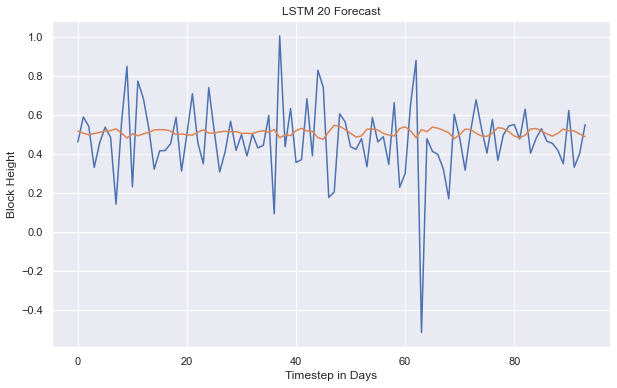

In [156]:
# recall best model
model = keras.models.load_model("my_checkpoint")
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()

# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plt.plot(normalized_x_test)
plt.plot(rnn_forecast)
plt.show()

## CNN

In [157]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/100
3/3 [==============================] - 1s 33ms/step - loss: 0.1192 - mae: 0.4804 - lr: 1.0000e-04
Epoch 2/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1176 - mae: 0.4772 - lr: 1.0798e-04
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1161 - mae: 0.4740 - lr: 1.1659e-04
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1145 - mae: 0.4705 - lr: 1.2589e-04
Epoch 5/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1127 - mae: 0.4668 - lr: 1.3594e-04
Epoch 6/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1109 - mae: 0.4629 - lr: 1.4678e-04
Epoch 7/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1089 - mae: 0.4586 - lr: 1.5849e-04
Epoch 8/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1068 - mae: 0.4540 - lr: 1.7113e-04
Epoch 9/100
3/3 [==============================] - 0s 24ms/step - loss: 0.1045 - mae: 0.4491 - lr: 1.8478e-04
Epoch 10/1

3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - mae: 0.0470 - lr: 0.0271
Epoch 75/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - mae: 0.0472 - lr: 0.0293
Epoch 76/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - mae: 0.0468 - lr: 0.0316
Epoch 77/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - mae: 0.0499 - lr: 0.0341
Epoch 78/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0036 - mae: 0.0478 - lr: 0.0369
Epoch 79/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - mae: 0.0471 - lr: 0.0398
Epoch 80/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0065 - mae: 0.0905 - lr: 0.0430
Epoch 81/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - mae: 0.0480 - lr: 0.0464
Epoch 82/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0034 - mae: 0.0455 - lr: 0.0501
Epoch 83/100
3/3 [==============================] 

In [158]:
#This is the best learning rate
history.history["lr"][history.history["loss"].index(min(history.history["loss"]))]

0.073564224

In [168]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=0.05)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model 
#model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

C:\Users\paletto\Anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/500
3/3 [==============================] - 2s 225ms/step - loss: 145.0429 - mae: 145.4421 - val_loss: 0.0162 - val_mae: 0.1407
Epoch 2/500
3/3 [==============================] - 0s 121ms/step - loss: 0.4280 - mae: 0.7426 - val_loss: 0.0799 - val_mae: 0.3756
Epoch 3/500
3/3 [==============================] - 0s 119ms/step - loss: 0.1265 - mae: 0.4379 - val_loss: 0.0649 - val_mae: 0.3347
Epoch 4/500
3/3 [==============================] - 0s 121ms/step - loss: 0.1931 - mae: 0.5471 - val_loss: 0.0880 - val_mae: 0.3960
Epoch 5/500
3/3 [==============================] - 0s 121ms/step - loss: 0.0714 - mae: 0.3677 - val_loss: 0.0560 - val_mae: 0.3086
Epoch 6/500
3/3 [==============================] - 0s 119ms/step - loss: 0.0415 - mae: 0.2752 - val_loss: 0.0320 - val_mae: 0.2218
Epoch 7/500
3/3 [==============================] - 0s 120ms/step - loss: 0.0200 - mae: 0.1835 - val_loss: 0.0175 - val_mae: 0.1492
Epoch 8/500
3/3 [==============================] - 0s 122ms/step - loss: 0.0082

3/3 [==============================] - 0s 118ms/step - loss: 0.0037 - mae: 0.0473 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 64/500
3/3 [==============================] - 0s 117ms/step - loss: 0.0037 - mae: 0.0471 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 65/500
3/3 [==============================] - 0s 117ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 66/500
3/3 [==============================] - 0s 116ms/step - loss: 0.0037 - mae: 0.0471 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 67/500
3/3 [==============================] - 0s 116ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 68/500
3/3 [==============================] - 0s 116ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 69/500
3/3 [==============================] - 0s 118ms/step - loss: 0.0037 - mae: 0.0472 - val_loss: 0.0111 - val_mae: 0.1077
Epoch 70/500
3/3 [==============================] - 0s 117ms/step - loss: 0.0037 - mae: 0

In [169]:
#model = keras.models.load_model("my_checkpoint.h5")
# Use best model to get forecasts
cnn_forecast = model_forecast(model, np.concatenate((normalized_x_valid[-20:], normalized_x_test)), window_size)
# spy_normalized_to_traindata
cnn_forecast = cnn_forecast[:,-1,0]
print(cnn_forecast.shape)
#cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()

(95,)


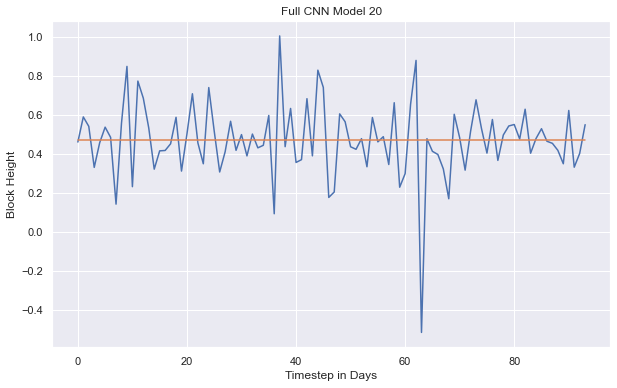

In [170]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Block Height')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plt.plot(normalized_x_test)
plt.plot(cnn_forecast[1:])